## Re-tracing IBB index

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict
%tensorflow_version 1.x

Using TensorFlow backend.


In [0]:
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DPT-data/last_price.csv', index_col=0)

In [0]:
stock_lp.head()

CELG    US Equity  ...  OPHT    US Equity
1/6/2012               67.22  ...                NaN
1/13/2012              72.63  ...                NaN
1/20/2012              73.84  ...                NaN
1/27/2012              73.37  ...                NaN
2/3/2012               73.21  ...                NaN

[5 rows x 163 columns]

In [0]:
stock_lp = stock_lp.dropna(axis=1, how='any').astype('float32')

In [0]:
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

In [0]:
stock_net = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DPT-data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

In [0]:
stock_percentage = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DPT-data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]

In [0]:
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DPT-data/ibb.csv', index_col=0).astype('float32')

In [0]:
ibb_full.head()

PX_LAST  Change  % Change
Date                                   
6/1/2012   107.209999    0.00  0.000000
13/1/2012  112.349998    5.14  4.794329
20/1/2012  113.000000    0.65  0.578549
27/1/2012  116.260002    3.26  2.884956
3/2/2012   120.639999    4.38  3.767418

In [0]:
ibb_lp = ibb_full.iloc[:,0]
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

In [0]:
ibb_net = ibb_full.iloc[:,1]
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2]
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

### Auto-encoder

In [0]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

In [0]:
stock_lp.columns

Index(['CELG    US Equity', 'GILD    US Equity', 'BIIB    US Equity',
       'AMGN    US Equity', 'REGN    US Equity', 'INCY    US Equity',
       'ILMN    US Equity', 'MYL     US Equity', 'VRTX    US Equity',
       'ALXN    US Equity', 'BMRN    US Equity', 'SHPG    US Equity',
       'SGEN    US Equity', 'ALKS    US Equity', 'JAZZ    US Equity',
       'QGEN    US Equity', 'UTHR    US Equity', 'EXEL    US Equity',
       'IONS    US Equity', 'OPK     US Equity', 'ALNY    US Equity',
       'ACAD    US Equity', 'TECH    US Equity', 'NKTR    US Equity',
       'MDCO    US Equity', 'NBIX    US Equity', 'AKRX    US Equity',
       'CLVS    US Equity', 'CBPO    US Equity', 'GRFS    US Equity',
       'ENDP    US Equity', 'HZNP    US Equity', 'IRWD    US Equity',
       'LGND    US Equity', 'HALO    US Equity', 'PCRX    US Equity',
       'SRPT    US Equity', 'ARRY    US Equity', 'LXRX    US Equity',
       'INVA    US Equity', 'MYGN    US Equity', 'ACOR    US Equity',
       'RGEN    US E

In [0]:
# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) 

In [0]:
# construct and compile autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

Training and saving the autoencoder

In [0]:
data = stock['calibrate']['net']

In [0]:
data.shape

(104, 83)

In [0]:
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)




Epoch 1/500





104/104 [==============================] - 1s 6ms/step - loss: 5.8075
Epoch 2/500
104/104 [==============================] - 0s 165us/step - loss: 5.5839
Epoch 3/500
104/104 [==============================] - 0s 140us/step - loss: 5.4835
Epoch 4/500
104/104 [==============================] - 0s 191us/step - loss: 5.4157
Epoch 5/500
104/104 [==============================] - 0s 184us/step - loss: 5.3603
Epoch 6/500
104/104 [==============================] - 0s 178us/step - loss: 5.3109
Epoch 7/500
104/104 [==============================] - 0s 136us/step - loss: 5.2599
Epoch 8/500
104/104 [==============================] - 0s 157us/step - loss: 5.2033
Epoch 9/500
104/104 [==============================] - 0s 125us/step - loss: 5.1393
Epoch 10/500
104/104 [==============================] - 0s 152us/step - loss: 5.0648
Epoch 11/500
104/104 [==============================] - 0s 150us/step - loss: 4.9831
Epoch 12/500
104/104 [==============================] - 0s 132us/ste

In [0]:

autoencoder.save('/content/drive/My Drive/Colab Notebooks/DPT-models/retrack_autoencoder.h5')

reconstruct market information matrix

In [0]:
reconstruct = autoencoder.predict(data)

communal Info

In [0]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
68 1.2854912281036377 TLGT    US Equity
65 1.3613708019256592 INO     US Equity
38 1.5799437761306763 LXRX    US Equity
76 1.8029533624649048 NVAX    US Equity
66 2.086078405380249 CERS    US Equity
79 2.1852056980133057 ZGNX    US Equity
77 2.3762965202331543 PDLI    US Equity
81 2.420624256134033 MNOV    US Equity
71 2.4770586490631104 CRIS    US Equity
52 2.8170888423919678 IMMU    US Equity
17 2.8346915245056152 EXEL    US Equity
49 3.0657877922058105 DEPO    US Equity
75 3.098550796508789 GERN    US Equity
37 3.4354870319366455 ARRY    US Equity
73 3.6363556385040283 AVDL    US Equity
67 3.6651108264923096 PACB    US Equity
48 3.8374359607696533 SGYP    US Equity
19 4.001040935516357 OPK     US Equity
42 4.111011505126953 RGEN    US Equity
72 4.21407413482666 PRTK    US Equity
55 4.220226764678955 BCRX    US Equity
31 4.224119186401367 HZNP    US Equity
82 4.323864936828613 ARWR    US Equity
80 4.615487575531006 CGEN    US Equity
44 4.8436198234558105 F

In [0]:
which_stock = 1

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

plot for comparison

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


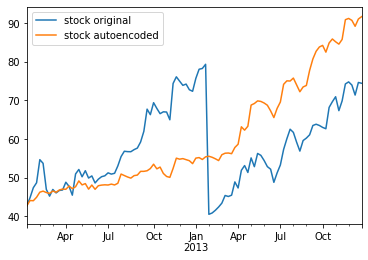

In [0]:
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

### Calibrating/Training


In [0]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

In [0]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
        
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
        
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('/content/drive/My Drive/Colab Notebooks/DPT-models/retrack_s' + str(s) + '.h5') # for validation phase use
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - ibb['calibrate']['lp']))

Epoch 1/500
104/104 [==============================] - 0s 1ms/step - loss: 8.5096
Epoch 2/500
104/104 [==============================] - 0s 133us/step - loss: 3.2966
Epoch 3/500
104/104 [==============================] - 0s 127us/step - loss: 2.0563
Epoch 4/500
104/104 [==============================] - 0s 119us/step - loss: 1.5607
Epoch 5/500
104/104 [==============================] - 0s 122us/step - loss: 1.2979
Epoch 6/500
104/104 [==============================] - 0s 131us/step - loss: 1.1243
Epoch 7/500
104/104 [==============================] - 0s 133us/step - loss: 1.0004
Epoch 8/500
104/104 [==============================] - 0s 121us/step - loss: 0.9056
Epoch 9/500
104/104 [==============================] - 0s 124us/step - loss: 0.8335
Epoch 10/500
104/104 [==============================] - 0s 129us/step - loss: 0.7775
Epoch 11/500
104/104 [==============================] - 0s 118us/step - loss: 0.7312
Epoch 12/500
104/104 [==============================] - 0s 117us/step - loss

plot results and 2-norm differences

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


S25 2-norm difference:  14.360262
S45 2-norm difference:  3.5733757
S65 2-norm difference:  7.0881243


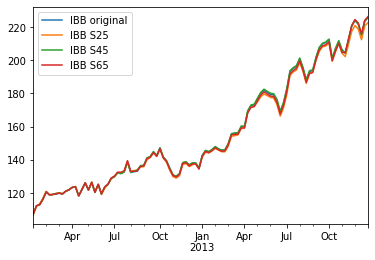

In [0]:
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB original', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])

### Validating

In [0]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('/content/drive/My Drive/Colab Notebooks/DPT-models/retrack_s' + str(s) + '.h5')
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)      
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

plot results and 2-norm differences

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


S25 2-norm difference:  1519.1299
S45 2-norm difference:  306.143
S65 2-norm difference:  397.90134


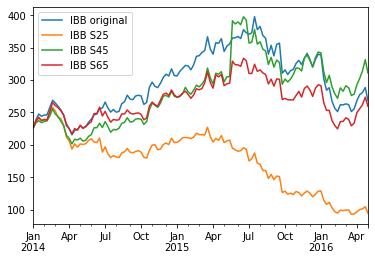

In [0]:
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['validate'][s])

### Verifying

In [0]:
error = []
for non_communal in range(5, 79, 1):  
    ab = non_communal
    print(ab,ab,ab,ab,ab,ab,ab,ab,ab,ab,ab,ab,ab,ab,ab,ab,ab,ab)
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock['calibrate']['percentage'].iloc[:, stock_index]
    y_train = ibb['calibrate']['percentage']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=500, batch_size = 10)    # fit the model


    # testing
    x_test = stock['validate']['percentage'].iloc[:, stock_index]
    y_test = ibb['validate']['percentage']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - ibb['validate']['lp'])))

5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
Epoch 1/500
104/104 [==============================] - 0s 3ms/step - loss: 9.3059
Epoch 2/500
104/104 [==============================] - 0s 138us/step - loss: 7.1274
Epoch 3/500
104/104 [==============================] - 0s 136us/step - loss: 6.3743
Epoch 4/500
104/104 [==============================] - 0s 129us/step - loss: 5.7851
Epoch 5/500
104/104 [==============================] - 0s 126us/step - loss: 5.1998
Epoch 6/500
104/104 [==============================] - 0s 130us/step - loss: 4.5135
Epoch 7/500
104/104 [==============================] - 0s 126us/step - loss: 3.8140
Epoch 8/500
104/104 [==============================] - 0s 127us/step - loss: 3.3042
Epoch 9/500
104/104 [==============================] - 0s 128us/step - loss: 2.9618
Epoch 10/500
104/104 [==============================] - 0s 142us/step - loss: 2.7491
Epoch 11/500
104/104 [==============================] - 0s 124us/step - loss: 2.5909
Epoch 12/500
104/104 [==================

Plot Efficient Deep Frontier

Text(0, 0.5, 'number of stocks in the portfolio')

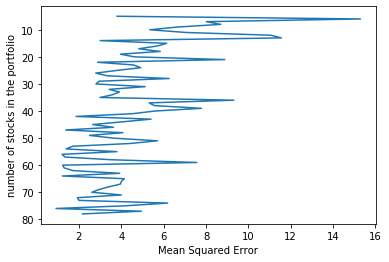

In [0]:
mse = [e/len(ibb['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,79,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio')

## To select a subset of stocks from IBB Index to beat the Index

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict

In [0]:
# Load data

# stock componenet data
stock = defaultdict(defaultdict)

stock_lp = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DPT-data/last_price.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['lp'] = stock_lp.iloc[0:104, :]
stock['validate']['lp'] = stock_lp.iloc[104:, :]

stock_net = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DPT-data/net_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['net'] = stock_net.iloc[0:104, :]
stock['validate']['net'] = stock_net.iloc[104:, :]

stock_percentage = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DPT-data/percentage_change.csv', index_col=0).dropna(axis=1, how='any').astype('float32')
stock['calibrate']['percentage'] = stock_percentage.iloc[0:104, :]
stock['validate']['percentage'] = stock_percentage.iloc[104:, :]


# ibb data
ibb = defaultdict(defaultdict)
ibb_full = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DPT-data/ibb.csv', index_col=0).astype('float32')

ibb_lp = ibb_full.iloc[:,0] # Series
ibb['calibrate']['lp'] = ibb_lp[0:104]
ibb['validate']['lp'] = ibb_lp[104:]

ibb_net = ibb_full.iloc[:,1] # Series
ibb['calibrate']['net'] = ibb_net[0:104]
ibb['validate']['net'] = ibb_net[104:]

ibb_percentage = ibb_full.iloc[:,2] # Series
ibb['calibrate']['percentage'] = ibb_percentage[0:104]
ibb['validate']['percentage'] = ibb_percentage[104:]

## Auto-encoding

In [48]:
encoding_dim = 5 # 5 neurons
num_stock = len(stock_lp.columns) # Use 83 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation= 'linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock['calibrate']['net']
autoencoder.fit(data, data, shuffle=False, epochs=500, batch_size = 10)
autoencoder.save('/content/drive/My Drive/Colab Notebooks/DPT-models/beat_autoencoder.h5')

# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

Epoch 1/500
104/104 [==============================] - 3s 27ms/step - loss: 5.8647
Epoch 2/500
104/104 [==============================] - 0s 186us/step - loss: 5.5606
Epoch 3/500
104/104 [==============================] - 0s 191us/step - loss: 5.4369
Epoch 4/500
104/104 [==============================] - 0s 173us/step - loss: 5.3581
Epoch 5/500
104/104 [==============================] - 0s 173us/step - loss: 5.2907
Epoch 6/500
104/104 [==============================] - 0s 177us/step - loss: 5.2241
Epoch 7/500
104/104 [==============================] - 0s 177us/step - loss: 5.1564
Epoch 8/500
104/104 [==============================] - 0s 178us/step - loss: 5.0834
Epoch 9/500
104/104 [==============================] - 0s 180us/step - loss: 5.0028
Epoch 10/500
104/104 [==============================] - 0s 178us/step - loss: 4.9095
Epoch 11/500
104/104 [==============================] - 0s 198us/step - loss: 4.8016
Epoch 12/500
104/104 [==============================] - 0s 187us/step - los

communal info

In [49]:
communal_information = []

for i in range(0,83):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock['calibrate']['net'].iloc[:,stock_index].name)

stock #, 2-norm, stock name
65 1.2894604206085205 INO     US Equity
68 1.3002784252166748 TLGT    US Equity
38 1.6216490268707275 LXRX    US Equity
76 1.8409630060195923 NVAX    US Equity
66 2.103142738342285 CERS    US Equity
79 2.2112905979156494 ZGNX    US Equity
81 2.4240849018096924 MNOV    US Equity
77 2.4254658222198486 PDLI    US Equity
71 2.515449285507202 CRIS    US Equity
52 2.8002097606658936 IMMU    US Equity
17 2.872810125350952 EXEL    US Equity
49 3.1010658740997314 DEPO    US Equity
75 3.115790843963623 GERN    US Equity
37 3.459808349609375 ARRY    US Equity
67 3.6687111854553223 PACB    US Equity
73 3.6839029788970947 AVDL    US Equity
48 3.8828537464141846 SGYP    US Equity
19 4.018004894256592 OPK     US Equity
42 4.129631519317627 RGEN    US Equity
55 4.202790260314941 BCRX    US Equity
31 4.22887659072876 HZNP    US Equity
72 4.234202861785889 PRTK    US Equity
82 4.375988006591797 ARWR    US Equity
80 4.606595039367676 CGEN    US Equity
44 4.880334377288818 FOLD

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


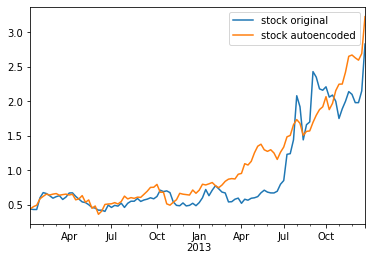

In [50]:
which_stock = 65

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock['calibrate']['lp'].iloc[0, which_stock])

## plot for comparison
pd.Series(stock['calibrate']['lp'].iloc[:, which_stock].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='stock original', legend=True)
pd.Series(stock_autoencoder, index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='stock autoencoded', legend=True)

### Calibrating

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


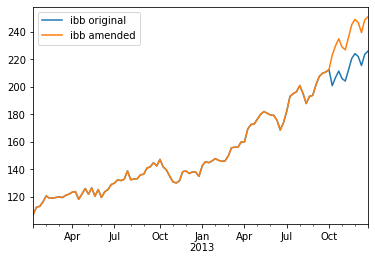

In [51]:
y_amended = ibb['calibrate']['percentage']
y_amended[y_amended < -5] = 5

# re-calculate the last price
y_amended[0] = 0
relative_percentage = (y_amended /100) + 1
lp_amended = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod()) 

# plot comparison
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb amended', legend=True)

In [52]:
ibb_predict = defaultdict(defaultdict)
total_2_norm_diff = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l2(0.005))(input_img)
    decoded = Dense(1, activation= 'linear', kernel_regularizer=regularizers.l2(0.005))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock['calibrate']['percentage'].iloc[:, stock_index]
    y = y_amended # amended percentage
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    deep_learner.fit(x, y, shuffle=False, epochs=500, batch_size = 10)    # fit the model
    deep_learner.save('/content/drive/My Drive/Colab Notebooks/DPT-models/beat_s' + str(s) + '.h5') # for validation phase use
    
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['calibrate'][s] = ibb['calibrate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff['calibrate'][s] = np.linalg.norm((ibb_predict['calibrate'][s] - lp_amended)) # compare with amended last price


Epoch 1/500
104/104 [==============================] - 3s 28ms/step - loss: 7.0204
Epoch 2/500
104/104 [==============================] - 0s 177us/step - loss: 4.1006
Epoch 3/500
104/104 [==============================] - 0s 173us/step - loss: 2.7490
Epoch 4/500
104/104 [==============================] - 0s 175us/step - loss: 2.1512
Epoch 5/500
104/104 [==============================] - 0s 177us/step - loss: 1.8532
Epoch 6/500
104/104 [==============================] - 0s 179us/step - loss: 1.6484
Epoch 7/500
104/104 [==============================] - 0s 179us/step - loss: 1.4990
Epoch 8/500
104/104 [==============================] - 0s 174us/step - loss: 1.3799
Epoch 9/500
104/104 [==============================] - 0s 180us/step - loss: 1.2821
Epoch 10/500
104/104 [==============================] - 0s 175us/step - loss: 1.2017
Epoch 11/500
104/104 [==============================] - 0s 183us/step - loss: 1.1239
Epoch 12/500
104/104 [==============================] - 0s 185us/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


S25 2-norm difference:  12.966817
S45 2-norm difference:  39.05298
S65 2-norm difference:  28.338665


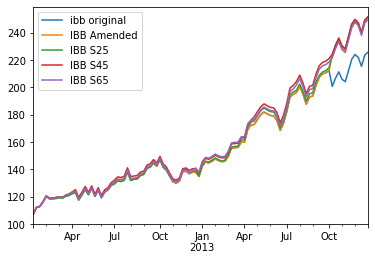

In [53]:
# plot results and 2-norm differences 
pd.Series(ibb['calibrate']['lp'].as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='ibb original', legend=True) 
pd.Series(lp_amended.as_matrix(), index=pd.date_range(start='01/06/2012', periods=104, freq='W')).plot(label='IBB Amended', legend=True)

for s in [25, 45, 65]:
    pd.Series(ibb_predict['calibrate'][s], index=pd.date_range(start='01/06/2012', periods = 104,freq='W')).plot(label='IBB S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff['calibrate'][s])

## Validating

In [0]:
for non_communal in [15, 35, 55]:  
    # some numerical values
    encoding_dim = 5
    s = 10 + non_communal
    stock_index = np.concatenate((ranking[0:10], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('/content/drive/My Drive/Colab Notebooks/DPT-models/beat_s' + str(s) + '.h5')
    
    x = stock['validate']['percentage'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage/100) + 1
    
    ibb_predict['validate'][s] = ibb['validate']['lp'][0] * (relative_percentage.cumprod())          
#     total_2_norm_diff['validate'][s] = np.linalg.norm((ibb_predict['validate'][s] - ibb['validate']['lp']))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


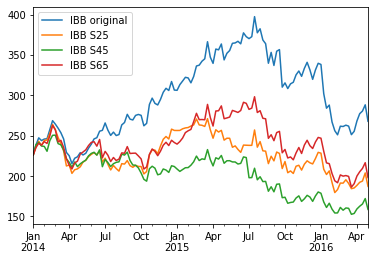

In [56]:
# plot original IBB last price
pd.Series(ibb['validate']['lp'].as_matrix(), index=pd.date_range(start='01/03/2014', periods=122, freq='W')).plot(label='IBB original', legend=True) 

# 2-norm difference is now meaningless to compare
for s in [25, 45, 65]:
    pd.Series(ibb_predict['validate'][s], index=pd.date_range(start='01/03/2014', periods = 122,freq='W')).plot(label='IBB S'+str(s), legend=True)

# Some problems I could not figure out (or the paper did not mention the details):

1. which weekly return/what data to be used? (what can represent best market information?)
2. How to do the data preprocessing?
3. The paper says that, AMGN should be the best, and BCRX should be the worst. (But I didn't achieve this result.)
4. [here](https://render.githubusercontent.com/view/ipynb?commit=d2eefcbc878bbe4507f238dc0d3f5d3d811ff59a&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f74636c6f61612f446565702d506f7274666f6c696f2d5468656f72792f643265656663626338373862626534353037663233386463306433663564336438313166663539612f50617274253230322532302d25323042656174253230494242253230496e6465782532305573696e6725323044656570253230506f7274666f6c696f2532305468656f72792e6970796e62&nwo=tcloaa%2FDeep-Portfolio-Theory&path=Part+2+-+Beat+IBB+Index+Using+Deep+Portfolio+Theory.ipynb&repository_id=81546984&repository_type=Repository#Phase-2:-Calibrating) he amended the target data during the calibration phase by replacing all returns smaller than -5% by exactly 5%, but why !
5. From my perspective Efficient Deep Frontier has nothing to do with the one in Modern Portfolio Theory. It just reflects the trade-off between more stocks in the portfolios and higher mean squared error (MSE).